# **Baixar Datase**

In [1]:
# Login No Kaggle
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# Baixar Dates

keltonmartins_colors_red_and_blue_path = kagglehub.dataset_download('keltonmartins/colors-red-and-blue')

print('Data source import complete.')


100%|██████████| 135M/135M [00:01<00:00, 87.1MB/s]

Extracting files...


Data source import complete.


# **Mover Dataset ---> Content**

In [3]:
import shutil
import os

pasta_origem = '/root/.cache/kagglehub/datasets/keltonmartins/colors-red-and-blue/versions/2/Dataset'
pasta_destino = '/content'

try:
    # Mover a pasta
    shutil.move(pasta_origem, pasta_destino)
    print(f"Pasta movida com sucesso de '{pasta_origem}' para '{pasta_destino}'")

except FileNotFoundError:
    print("Erro: O caminho de origem não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao mover a pasta: {e}")

Pasta movida com sucesso de '/root/.cache/kagglehub/datasets/keltonmartins/colors-red-and-blue/versions/2/Dataset' para '/content'


# **Libs Necessárias**

In [4]:
import os, cv2, glob as gb
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, BatchNormalization, Rescaling, Input
from keras.layers import LeakyReLU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.applications import MobileNetV3Small, MobileNetV2
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v3 import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.utils import shuffle

import pandas as pd
import warnings

# **Carregar Dateset**

In [5]:
#  Configs Padrões
path_dataset = '/content/Dataset/'
image_size = (32, 32)
X, Y = [], []

In [6]:
tipo = 0
pastas = sorted(os.listdir(path_dataset))
for pasta in pastas:
    arquivos = sorted(gb.glob(f"{path_dataset}{pasta}/*"))
    cont = 0
    for arquivo in arquivos:
      cont += 1
      imagem = cv2.imread(arquivo)
      imagem = cv2.resize(imagem, image_size)
      imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
      X.append(imagem)
      Y.append(tipo)

    # 0 Azul | 1 Vermelho
    tipo += 1

In [7]:
# Conversão para Numpy Array
X = np.array(X)
Y = np.array(Y)

# **Exibir Imagens**

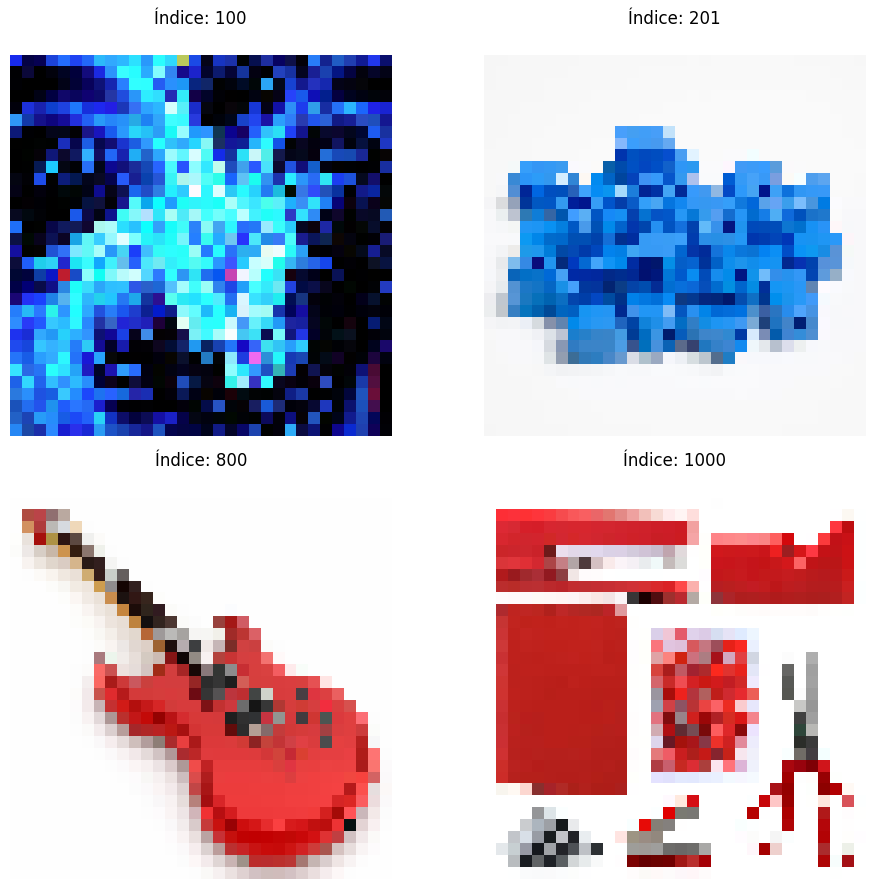

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 9))

ax_list = ax.flatten()

indices = [100, 201, 800, 1000]

for i, indice in enumerate(indices):
    ax_list[i].matshow(X[indice])

    ax_list[i].set_title(f"Índice: {indice}")
    ax_list[i].axis('off')

plt.tight_layout()
plt.show()

# **Preparar Dateset**

In [8]:
# Embaralhar as imagens
X, Y = shuffle(X, Y, random_state=42)

In [9]:
# Dividir Treinamento, Teste e Validação
X_treino, X_teste, y_treino, y_teste = train_test_split(X, Y, test_size=0.3, random_state=42)
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, random_state=42)

In [10]:
# Pré-processamento
X_treino = preprocess_input(X_treino)
X_teste = preprocess_input(X_teste)
X_val = preprocess_input(X_val)

# **Modelo MobileNet V3 Small**

In [ ]:
modelV3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
modelV3.trainable = False

modeloV3 = Sequential()
modeloV3.add(modelV3)
modeloV3.add(GlobalAveragePooling2D())
modeloV3.add(Dense(32, activation=LeakyReLU(0.01), kernel_regularizer=l2(0.001)))
modeloV3.add(Dropout(0.4))
modeloV3.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

modeloV3.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
modeloV3.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 1, 1, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 957,617 (3.65 MB)

 Trainable params: 18,497 (72.25 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
checkpoint1_V3 = ModelCheckpoint('modeloV3.keras', monitor='val_loss', save_best_only=True, mode="min", verbose=1)
checkpoint2_V3 = ModelCheckpoint('modeloV3.keras', monitor='val_loss', save_best_only=True, mode="min", verbose=1)

## **Treinamento 1**

In [ ]:
epocas = 50
H1_V3 = modeloV3.fit(X_treino, y_treino,
                batch_size=16,
                epochs=epocas,
                validation_data=(X_val, y_val),
                callbacks=[checkpoint1_V3]
              )

Epoch 1/50
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5674 - loss: 0.7665
Epoch 1: val_loss did not improve from 0.47289
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5748 - loss: 0.7601 - val_accuracy: 0.6974 - val_loss: 0.6572
Epoch 2/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7046 - loss: 0.6444
Epoch 2: val_loss did not improve from 0.47289
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7043 - loss: 0.6442 - val_accuracy: 0.7039 - val_loss: 0.6024
Epoch 3/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7451 - loss: 0.5650
Epoch 3: val_loss did not improve from 0.47289
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7446 - loss: 0.5654 - val_accuracy: 0.7303 - val_loss: 0.5553
Epoch 4/50
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7688 - loss: 0.5309
Epoch 4: val_loss did not improve from 0.47289
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7673 - loss: 0.5328 - val_accuracy: 0.7237 - val_loss: 0.5409
Epoch 5/50

## **Carregar Melhor modelo e Liberar Treinamento**

In [ ]:
modelV3.trainable = True
modeloV3.load_weights('modeloV3.keras')
modeloV3.compile(optimizer=Adam(2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## **Treinamento 2**

In [ ]:
epocas_fase2 = 600
H2_V3 = modeloV3.fit(X_treino, y_treino,
                batch_size=16,
                epochs=epocas_fase2,
                validation_data=(X_val, y_val),
                callbacks=[checkpoint2_V3]
              )

Epoch 1/700
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5161 - loss: 2.7993
Epoch 1: val_loss improved from inf to 0.49341, saving model to modelo.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - accuracy: 0.5160 - loss: 2.7947 - val_accuracy: 0.7895 - val_loss: 0.4934
Epoch 2/700
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4806 - loss: 2.3321
Epoch 2: val_loss did not improve from 0.49341
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4810 - loss: 2.3326 - val_accuracy: 0.7632 - val_loss: 0.5387
Epoch 3/700
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5112 - loss: 2.2169
Epoch 3: val_loss did not improve from 0.49341
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5110 - loss: 2.2151 - val_accuracy: 0.7566 - val_loss: 0.5834
Epoch 4/700
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5182 - loss: 2.1931
Epoch 4: val_loss did not improve from 0.49341
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5188 - loss: 2.1863 - val_accuracy

## **Resultados**

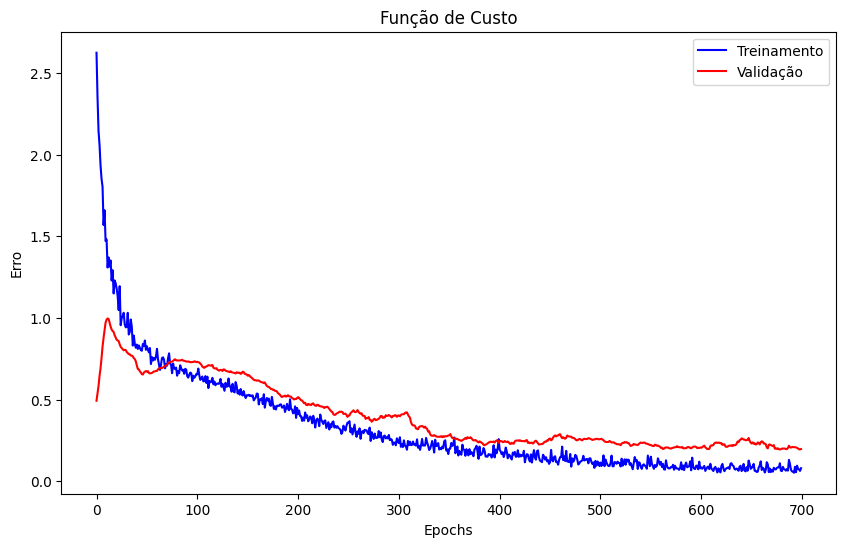

In [ ]:
# Função de custo
plt.figure(figsize=(10, 6))
plt.plot(H2_V3.history['loss'], c='blue', label='Treinamento')
plt.plot(H2_V3.history['val_loss'], c='red', label='Validação')
plt.ylabel('Erro')
plt.xlabel('Epochs')
plt.title('Função de Custo')
plt.legend()
plt.show()

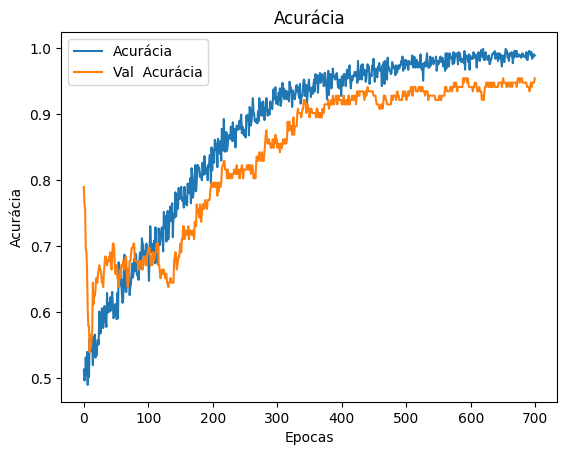

In [ ]:
# Acuracia
plt.plot(H2_V3.history['accuracy'], label='Acurácia')
plt.plot(H2_V3.history['val_accuracy'], label='Val  Acurácia')
plt.title('Acurácia')
plt.xlabel('Epocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

## **Predição**

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


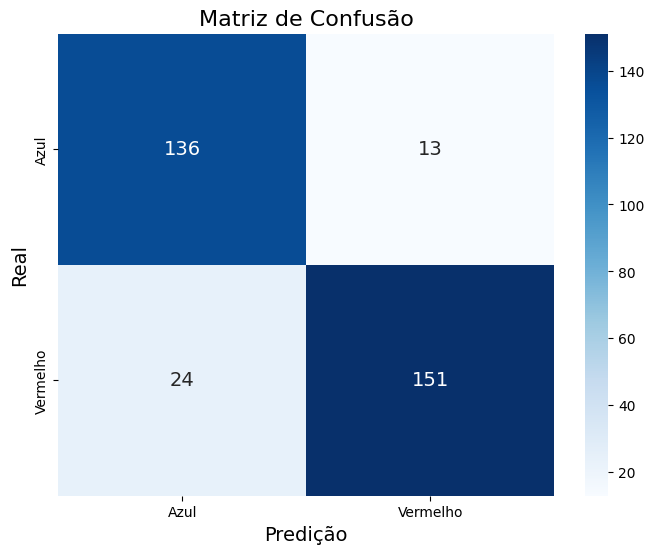

In [ ]:
y_pred = modeloV3.predict(X_teste)
y_pred = np.round(y_pred).flatten()

class_labels = ['Azul', 'Vermelho']

cm = confusion_matrix(y_teste, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            annot_kws={'size': 14})

plt.title('Matriz de Confusão', fontsize=16)
plt.xlabel('Predição', fontsize=14)
plt.ylabel('Real', fontsize=14)

# Exibindo a matriz de confusão
plt.show()

# **Modelo MobileNet V2**

In [ ]:
modelV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
modelV2.trainable = False

modeloV2 = Sequential()
modeloV2.add(modelV2)
modeloV2.add(GlobalAveragePooling2D())
modeloV2.add(Dense(32, activation=LeakyReLU(0.01), kernel_regularizer=l2(0.001)))
modeloV2.add(Dropout(0.4))
modeloV2.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

modeloV2.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
modeloV2.summary()

/tmp/ipython-input-64174981.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  modelV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,299,009 (8.77 MB)

 Trainable params: 41,025 (160.25 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **Callbacks**

In [ ]:
checkpoint1_V2 = ModelCheckpoint('modeloV2.keras', monitor='val_loss', save_best_only=True, mode="min", verbose=1)
checkpoint2_V2 = ModelCheckpoint('modeloV2.keras', monitor='val_loss', save_best_only=True, mode="min", verbose=1)

## **Treinamento 1**

In [ ]:
epocas = 50
H1_V2 = modeloV2.fit(X_treino, y_treino,
                batch_size=16,
                epochs=epocas,
                validation_data=(X_val, y_val),
                callbacks=[checkpoint1_V2]
              )

Epoch 1/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5688 - loss: 0.7312
Epoch 1: val_loss improved from inf to 0.65189, saving model to modeloV2.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.5714 - loss: 0.7301 - val_accuracy: 0.7368 - val_loss: 0.6519
Epoch 2/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7006 - loss: 0.6608
Epoch 2: val_loss improved from 0.65189 to 0.61252, saving model to modeloV2.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6997 - loss: 0.6607 - val_accuracy: 0.7632 - val_loss: 0.6125
Epoch 3/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6820 - loss: 0.6434
Epoch 3: val_loss improved from 0.61252 to 0.58133, saving model to modeloV2.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6826 - loss: 0.6430 - val_accuracy: 0.7895 - val_loss: 0.5813
Epoch 4/50
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7087 - loss: 0.6105
Epoch 4: val_loss improved from 0.58133 to 0.55814, saving model to

## **Descongelamento e Ajustes**

In [ ]:
modelV2.trainable = True
modeloV2.load_weights('modeloV2.keras')
modeloV2.compile(optimizer=Adam(2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## **Treinamento 2**

In [ ]:
epocas_fase2 = 270
H2_V2 = modeloV2.fit(X_treino, y_treino,
                batch_size=16,
                epochs=epocas_fase2,
                validation_data=(X_val, y_val),
                callbacks=[checkpoint2_V2]
              )

Epoch 1/270
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5042 - loss: 2.4047
Epoch 1: val_loss improved from inf to 0.66275, saving model to modeloV2.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - accuracy: 0.5044 - loss: 2.4056 - val_accuracy: 0.6776 - val_loss: 0.6627
Epoch 2/270
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5346 - loss: 1.9796
Epoch 2: val_loss improved from 0.66275 to 0.61552, saving model to modeloV2.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.5353 - loss: 1.9761 - val_accuracy: 0.6579 - val_loss: 0.6155
Epoch 3/270
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5947 - loss: 1.3317
Epoch 3: val_loss did not improve from 0.61552
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.5943 - loss: 1.3334 - val_accuracy: 0.6579 - val_loss: 0.6370
Epoch 4/270
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5642 - loss: 1.4938
Epoch 4: val_loss did not improve from 0.61552
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - acc

## **Resultados**

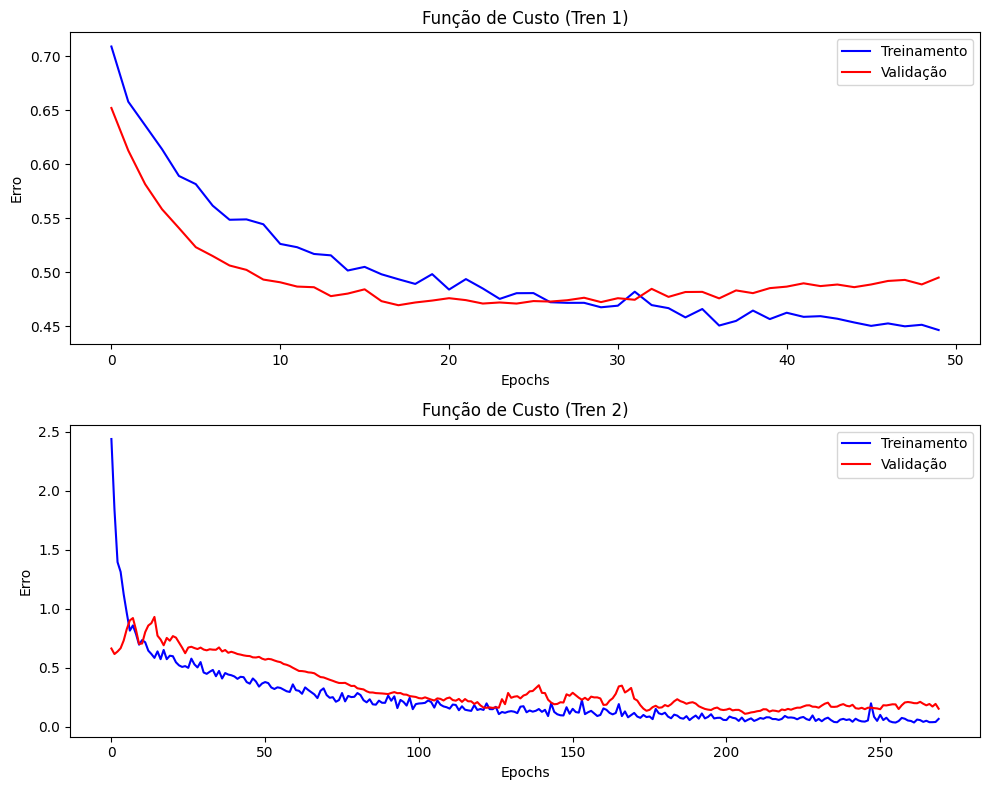

In [ ]:
# Função de custo

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# --- Primeiro Subplot (H1_V2) ---
ax1.plot(H1_V2.history['loss'], c='blue', label='Treinamento')
ax1.plot(H1_V2.history['val_loss'], c='red', label='Validação')
ax1.set_ylabel('Erro')
ax1.set_xlabel('Epochs')
ax1.set_title('Função de Custo (Tren 1)')
ax1.legend()

# --- Segundo Subplot (H2_V2) ---
ax2.plot(H2_V2.history['loss'], c='blue', label='Treinamento')
ax2.plot(H2_V2.history['val_loss'], c='red', label='Validação')
ax2.set_ylabel('Erro')
ax2.set_xlabel('Epochs')
ax2.set_title('Função de Custo (Tren 2)')
ax2.legend()

plt.tight_layout()
plt.show()

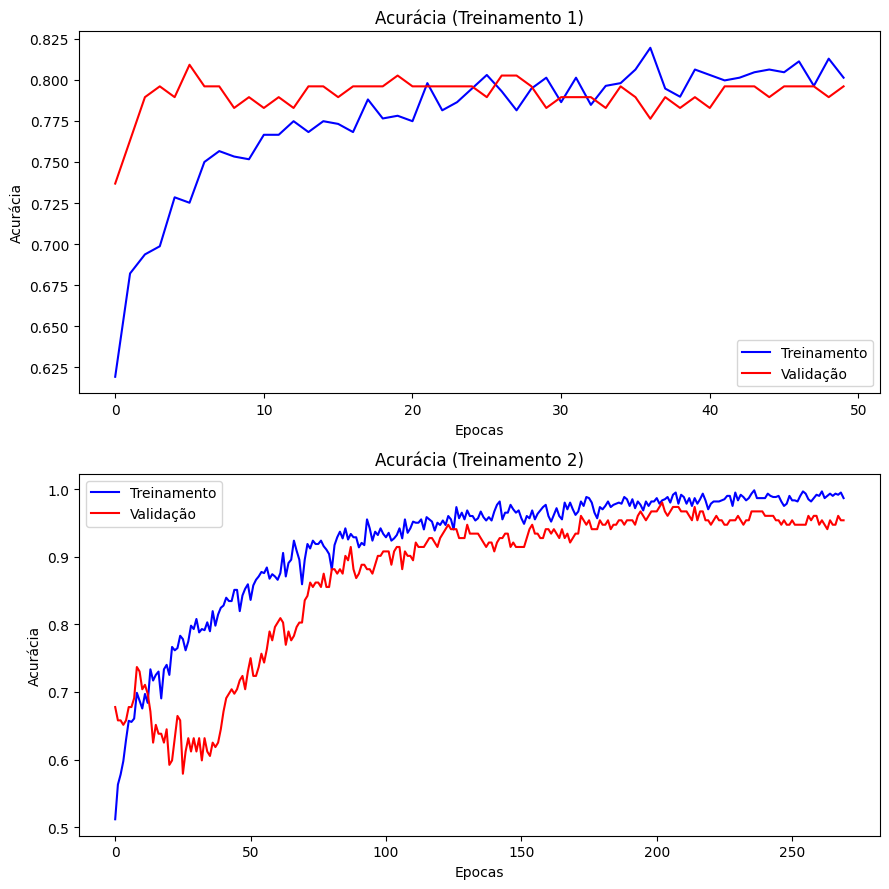

In [ ]:
# Acuracia
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 9))

# --- Primeiro Subplot (H1_V2) ---
ax1.plot(H1_V2.history['accuracy'], c='blue', label='Treinamento')
ax1.plot(H1_V2.history['val_accuracy'], c='red', label='Validação')
ax1.set_ylabel('Acurácia')
ax1.set_xlabel('Epocas')
ax1.set_title('Acurácia (Treinamento 1)')
ax1.legend()

# --- Segundo Subplot (H2_V2) ---
ax2.plot(H2_V2.history['accuracy'], c='blue', label='Treinamento')
ax2.plot(H2_V2.history['val_accuracy'], c='red', label='Validação')
ax2.set_ylabel('Acurácia')
ax2.set_xlabel('Epocas')
ax2.set_title('Acurácia (Treinamento 2)')
ax2.legend()

plt.tight_layout()
plt.show()

## **Predição**

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step


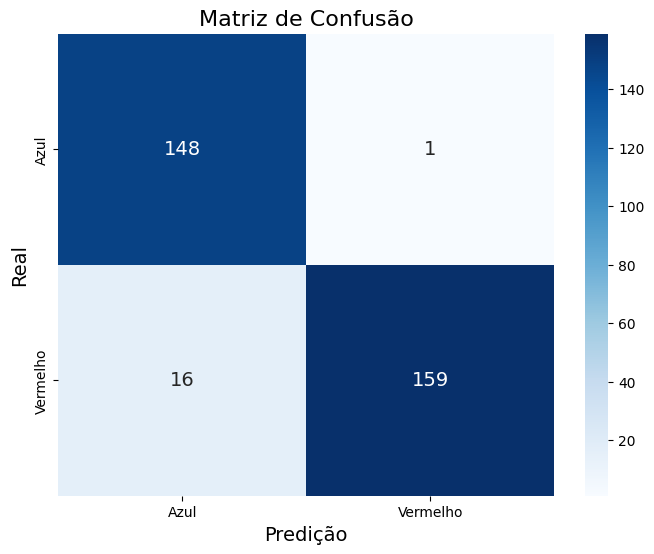

In [ ]:
y_pred = modeloV2.predict(X_teste)
y_pred = np.round(y_pred).flatten()

class_labels = ['Azul', 'Vermelho']

cm = confusion_matrix(y_teste, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            annot_kws={'size': 14})

plt.title('Matriz de Confusão', fontsize=16)
plt.xlabel('Predição', fontsize=14)
plt.ylabel('Real', fontsize=14)

# Exibindo a matriz de confusão
plt.show()

# **Modelo Customizado**

## **Arqutetura do Modelo**

In [ ]:
# Modelo CNN simples
model = Sequential([
    # Entrada: imagens 32x32 RGB
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilação
model.compile(
    optimizer=Adam(1e-6),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,977 (652.25 KB)

 Trainable params: 166,977 (652.25 KB)

 Non-trainable params: 0 (0.00 B)

## **Callbacks**

In [ ]:
checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, mode="min", verbose=1)

## **Treinamento**

In [ ]:
# Epocas
epocas = 250

# Treinamento
H = model.fit(X_treino, y_treino,
              batch_size=8,
              epochs=epocas,
              verbose=2,
              validation_data=(X_teste, y_teste),
              callbacks=[checkpoint])

Epoch 1/250

Epoch 1: val_loss improved from inf to 7.42128, saving model to model.keras
76/76 - 7s - 98ms/step - accuracy: 0.4238 - loss: 14.4269 - val_accuracy: 0.3580 - val_loss: 7.4213
Epoch 2/250

Epoch 2: val_loss improved from 7.42128 to 6.32576, saving model to model.keras
76/76 - 1s - 18ms/step - accuracy: 0.4238 - loss: 14.2683 - val_accuracy: 0.4105 - val_loss: 6.3258
Epoch 3/250

Epoch 3: val_loss improved from 6.32576 to 5.49814, saving model to model.keras
76/76 - 1s - 18ms/step - accuracy: 0.4669 - loss: 12.4395 - val_accuracy: 0.4383 - val_loss: 5.4981
Epoch 4/250

Epoch 4: val_loss improved from 5.49814 to 4.77607, saving model to model.keras
76/76 - 1s - 18ms/step - accuracy: 0.4950 - loss: 10.6989 - val_accuracy: 0.5062 - val_loss: 4.7761
Epoch 5/250

Epoch 5: val_loss improved from 4.77607 to 4.24055, saving model to model.keras
76/76 - 1s - 17ms/step - accuracy: 0.4818 - loss: 11.5664 - val_accuracy: 0.5432 - val_loss: 4.2405
Epoch 6/250

Epoch 6: val_loss improved

## **Resultados**

### **Acuracia do Modelo**

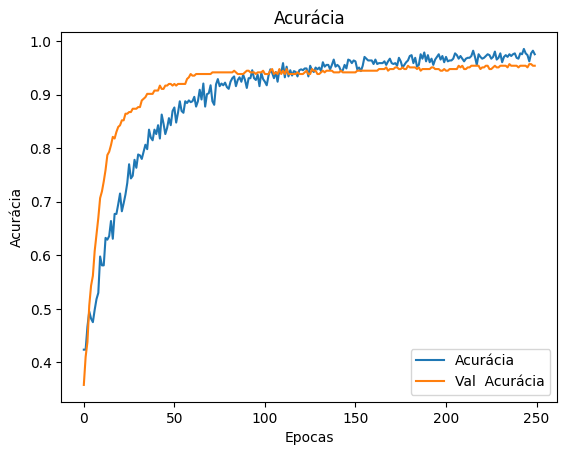

In [ ]:
# Acuracia
plt.plot(H.history['accuracy'], label='Acurácia')
plt.plot(H.history['val_accuracy'], label='Val  Acurácia')
plt.title('Acurácia')
plt.xlabel('Epocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

### **Erro do Modelo**

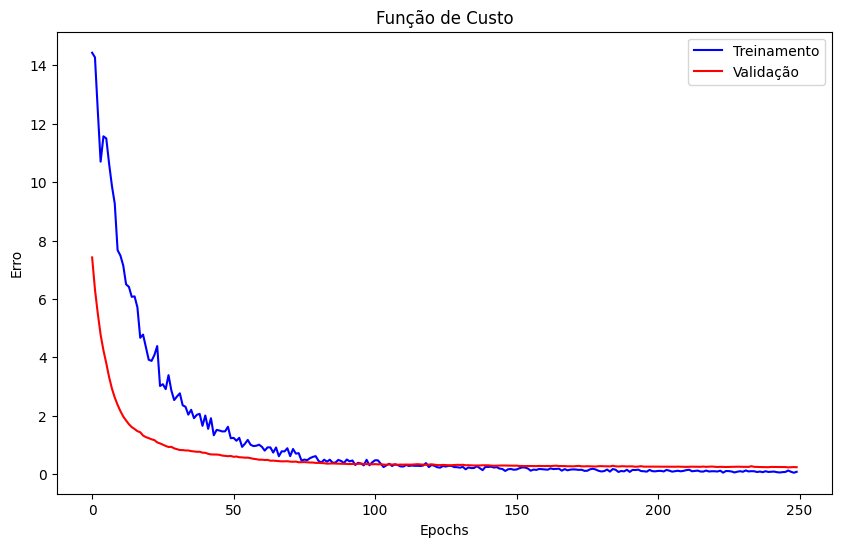

In [ ]:
# Função de custo
plt.figure(figsize=(10, 6))
plt.plot(H.history['loss'], c='blue', label='Treinamento')
plt.plot(H.history['val_loss'], c='red', label='Validação')
plt.ylabel('Erro')
plt.xlabel('Epochs')
plt.title('Função de Custo')
plt.legend()
plt.show()

# **Teste do modelo**

In [ ]:
modelo_test = load_model('modeloV2.keras')

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


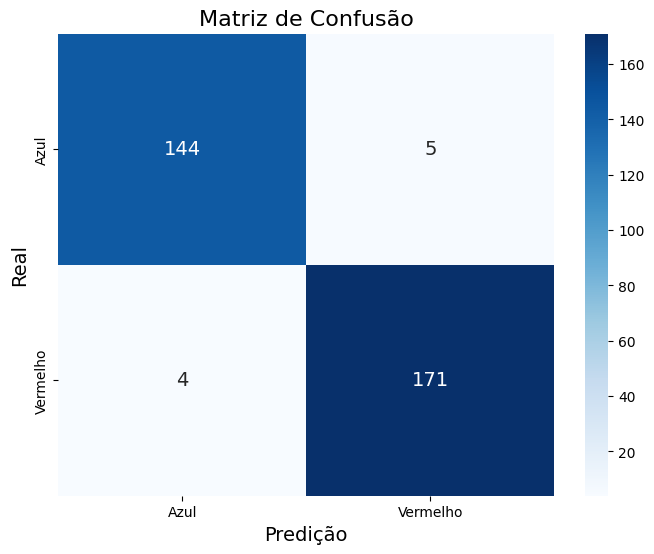

In [ ]:
y_pred = modelo_test.predict(X_teste)
y_pred = np.round(y_pred).flatten()

class_labels = ['Azul', 'Vermelho']

cm = confusion_matrix(y_teste, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            annot_kws={'size': 14})

plt.title('Matriz de Confusão', fontsize=16)
plt.xlabel('Predição', fontsize=14)
plt.ylabel('Real', fontsize=14)

# Exibindo a matriz de confusão
plt.show()

# **CNN --> TFLITE**

## **Conversão .Keras --> .tflite**

### **Carregar modelo Keras**

In [13]:
modelo_test = load_model('modeloV2.keras')

### **Conversão para Lite normal**

In [ ]:
# Sem quantização
conversor = tf.lite.TFLiteConverter.from_keras_model(modelo_test)
modelo_lite = conversor.convert()

with open('v3_Normal.tflite', 'wb') as f:
  f.write(modelo_lite)

Saved artifact at '/tmp/tmp6miw4ngp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer_27')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133667193192528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667175038032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667175038224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667193207696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667194454864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667175038416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667175038608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667175029200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667175037840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667175036496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13366717503668

### **Conversão com quantização dinamica**

In [ ]:
# Com quantização dinamica
conversor = tf.lite.TFLiteConverter.from_keras_model(modelo_test)
conversor.optimizations = [tf.lite.Optimize.DEFAULT]
modelo_lite = conversor.convert()

with open('v3_Dinamica.tflite', 'wb') as f:
  f.write(modelo_lite)

Saved artifact at '/tmp/tmpu2ti5fsr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer_27')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133667176567184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667176577936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667176578128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667176578512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667176577360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667176578320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667176576592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667176576784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667176577552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133667176576016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13366717656699

### **Conversão inteira**

In [14]:
# --- Função de calibração com X_val ---
def representative_dataset():
    for i in range(min(250, len(X_teste))):
        img = X_teste[i].astype(np.float32)
        img = np.expand_dims(img, axis=0)

        # Se preprocess_input retorna tensor, converta:
        if isinstance(img, tf.Tensor):
            img = img.numpy()

        yield [img]

converter = tf.lite.TFLiteConverter.from_keras_model(modelo_test)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter._experimental_disable_per_channel = False

# --- Converte ---
modelo_quantizado = converter.convert()

# --- Salva ---
with open("v2_Inteira.tflite", "wb") as f:
    f.write(modelo_quantizado)

Saved artifact at '/tmp/tmpv6rvprd6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139316551828880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313707970064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313707969680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313707970256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313707969104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313707968912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313707974096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313707974480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313707969296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313707973520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313707969872

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


## **Carregar modelo TFLITE**

In [ ]:
interpreter = tf.lite.Interpreter(model_path="modelo_lite.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

[{'name': 'serving_default_input_layer_3:0', 'index': 0, 'shape': array([ 1, 32, 32,  3], dtype=int32), 'shape_signature': array([-1, 32, 32,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 176, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


# **Inferência TFLITE**

## **Carregar modelo TFLITE**

In [ ]:
interpreter = tf.lite.Interpreter(model_path="modelo_lite.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

[{'name': 'serving_default_input_layer_3:0', 'index': 0, 'shape': array([ 1, 32, 32,  3], dtype=int32), 'shape_signature': array([-1, 32, 32,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 176, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


## **Escolhendo IMG para teste**

Classificação: 1



<Figure size 600x600 with 0 Axes>

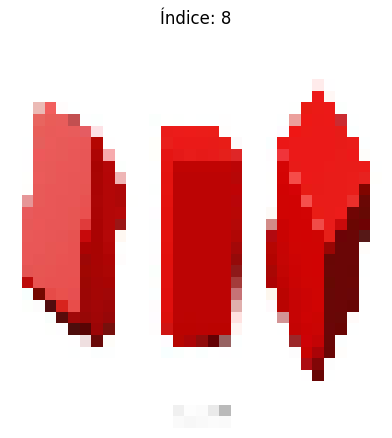

In [ ]:
# Imagem de Teste

# Escolha o índice da imagem 0 - 323
indice_selecionado = 8

print(f"Classificação: {y_teste[indice_selecionado]}\n")

img = X_teste[indice_selecionado]

plt.figure(figsize=(6, 6))

plt.matshow(img)

plt.title(f"Índice: {indice_selecionado}")
plt.axis('off')

plt.show()

## **Preparação Para Float, necessario para quantização normal ou dinâmica**

In [ ]:
# Pre preparação da imagem
img = img.astype(np.float32z)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)

# Informações da imagem
print(f"Tipo: {type(img)}")
print(f"Dtype: {img.dtype}")
print(f"Shape: {img.shape}")

Tipo: <class 'numpy.ndarray'>
Dtype: int8
Shape: (1, 32, 32, 3)


## **Chamando o Invoke**

In [ ]:
interpreter.set_tensor(input_details[0]['index'], img)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])[0][0]

print(np.around(output_data))


1.0


## **Preparação da img para inteiro, necessario para quantização inteira**

In [ ]:
# Pre preparação da imagem
scale_in, zero_in = input_details[0]['quantization']
scale_out, zero_out = output_details[0]['quantization']

img = img.astype(np.float32)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)

img = ((img / scale_in) + zero_in).astype(np.int8)

# Informações da imagem
print(f"Tipo: {type(img)}")
print(f"Dtype: {img.dtype}")
print(f"Shape: {img.shape}")

Tipo: <class 'numpy.ndarray'>
Dtype: int8
Shape: (1, 32, 32, 3)


## **Chamando o Invoke**

In [ ]:
interpreter.set_tensor(input_details[0]['index'], img)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])[0][0]

output_float = (float(output_data) - float(zero_out)) * float(scale_out)

print(np.around(output_float))


1.0


# ESP32-S3 DevKitC 1 - Informações e Especificações
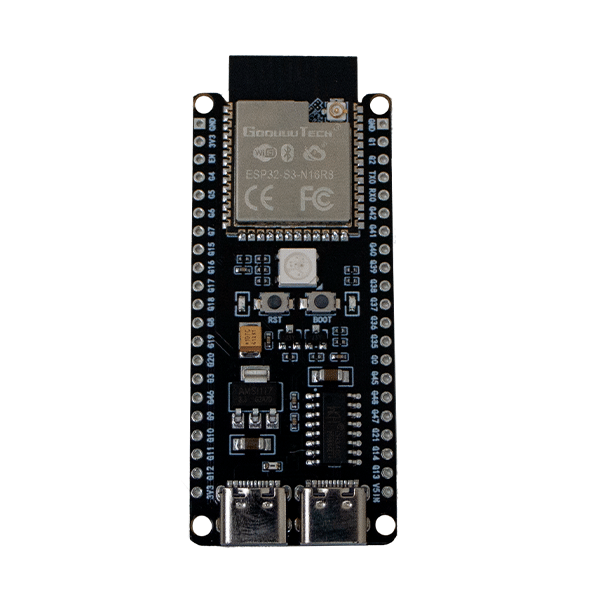

---

## Sobre a Placa

A **ESP32-S3 DevKitC 1** é uma placa de desenvolvimento baseada no microcontrolador ESP32-S3, projetada para aplicações que exigem alto desempenho, conectividade Wi-Fi e Bluetooth, e capacidade de processamento eficiente. Ela é ideal para projetos de IoT, automação, robótica e prototipagem rápida.

---

## Informações de Memória (Teste em Codigo)



===== ESP32-S3 MEMORY INFO ===== <br>
Free heap: 361964 bytes<br>
Total heap: 397084 bytes<br>
Free internal RAM: 361964 bytes<br>
Flash size (bytes): 16777216<br>
Flash speed (Hz): 80000000<br>

===== INTERNAL MEMORY INFO ===== <br>
Free internal RAM: 361972 bytes<br>
Largest free block (internal): 303092 bytes



Esses dados podem variar dependendo do programa carregado na placa e da utilização de recursos.

---

## Especificações Técnicas (Fabricante)

- **Microcontrolador:** ESP32-S3-WROOM-1-N16R8  
- **CPU:** Xtensa® Dual-Core 32-bit LX7  
- **Velocidade do Clock:** 240 MHz  
- **Conectividade:**
  - Wi-Fi 802.11 b/g/n 2.4 GHz  
  - Suporte a Wi-Fi Direct (P2P), P2P Discovery, P2P Group Owner mode, P2P Power Management  
  - Bluetooth BLE 5  
- **Pinos I/O Digitais:** 36  
- **Portas Analógicas:** 16  
- **Número Total de Pinos:** 42  
- **DAC:** 2  
- **Tensão de Operação:** 3,3 VDC  
- **Tensão de Alimentação:** 5 VDC  
- **Corrente Máxima nos Pinos I/O:** 20 mA  
- **Memória Flash:** 16 MB  
- **PSRAM:** 8 MB  
- **SRAM:** 512 KB  
- **ROM:** 384 KB  
- **Dimensões:** 68 mm x 28 mm x 4,5 mm (desconsiderando os pinos)

---

## Observações

- Esta placa é compatível com o **ESP-IDF**, **Arduino IDE** e **MicroPython**, tornando-a muito versátil para diferentes tipos de projetos.  
- O desempenho real pode variar dependendo do uso de Wi-Fi, Bluetooth e periféricos conectados.  
- É recomendável sempre verificar o consumo de memória para evitar travamentos em aplicações mais complexas.

---


# **Comparação dos Modelos: V2, V3 e Customizado**

## **Inferência para quantização normal e dinâmica**

In [11]:
def inferencia_tflite_float(model_path, X_teste, input_details, output_details):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_index = input_details[0]['index']
    output_index = output_details[0]['index']

    predicoes = []
    for i in range(len(X_teste)):
        img = X_teste[i]
        img = img.astype(np.float32)
        img = np.expand_dims(img, axis=0)
        interpreter.set_tensor(input_index, img)
        interpreter.invoke()

        output_data = interpreter.get_tensor(output_index)
        predicao_binaria = np.around(output_data[0][0])
        predicoes.append(predicao_binaria)

    return np.array(predicoes)

## **Inferência para quantização inteira**

In [12]:
def inferencia_tflite_int8(model_path, X_teste):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    scale_in, zero_in = input_details[0]['quantization']
    scale_out, zero_out = output_details[0]['quantization']
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']

    predicoes = []
    for i in range(len(X_teste)):
        img = X_teste[i]
        img = img.astype(np.float32)
        img = np.expand_dims(img, axis=0)

        img_quant = ((img / scale_in) + zero_in).astype(input_details[0]['dtype'])

        interpreter.set_tensor(input_index, img_quant)
        interpreter.invoke()

        output_data = interpreter.get_tensor(output_index)[0][0]

        output_float = (float(output_data) - float(zero_out)) * float(scale_out)

        predicao_binaria = np.around(output_float)
        predicoes.append(predicao_binaria)

    return np.array(predicoes)

## **Plotar Matrizes de Confusão**

In [13]:
def plot_confusion_matrix(cm, model_name, class_labels, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels,
                annot_kws={'size': 10},
                ax=ax, cbar=False)
    ax.set_title(f'CM: {model_name}', fontsize=12)
    ax.set_xlabel('Predição')
    ax.set_ylabel('Real')

## **Comparação**

In [14]:
def comparar_modelos(modelos_config, X_teste, y_teste, class_labels):
    resultados_metricas = []

    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    for idx, config in enumerate(modelos_config):
        model_name = config['nome']
        model_path = config['caminho']
        model_type = config['tipo']

        try:
            if model_type == 'int8':
                predicoes = inferencia_tflite_int8(model_path, X_teste)
            else:
                temp_interpreter = tf.lite.Interpreter(model_path=model_path)
                temp_interpreter.allocate_tensors()
                input_details = temp_interpreter.get_input_details()
                output_details = temp_interpreter.get_output_details()
                predicoes = inferencia_tflite_float(model_path, X_teste, input_details, output_details)

        except Exception as e:
            print(f"ERRO ao carregar/inferir {model_name}: {e}")
            continue

        cm = confusion_matrix(y_teste, predicoes)

        relatorio = classification_report(y_teste, predicoes, target_names=class_labels, output_dict=True)
        acuracia = accuracy_score(y_teste, predicoes)

        resultados_metricas.append({
            'Modelo': model_name,
            'Acurácia': acuracia,
            'Precisão (Média)': relatorio['macro avg']['precision'],
            'Recall (Média)': relatorio['macro avg']['recall'],
            'F1-Score (Média)': relatorio['macro avg']['f1-score'],
            'CM': cm
        })

        plot_confusion_matrix(cm, model_name, class_labels, axes[idx])

    plt.tight_layout()
    plt.show()

    return resultados_metricas

## **Resultado**

### **Desativar Warnings. Recomendo migrrar para o ai_edge_litert**

In [15]:
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="tensorflow.lite.python.interpreter"
)

tf.get_logger().setLevel('ERROR')

### **Matriz de Confusão**

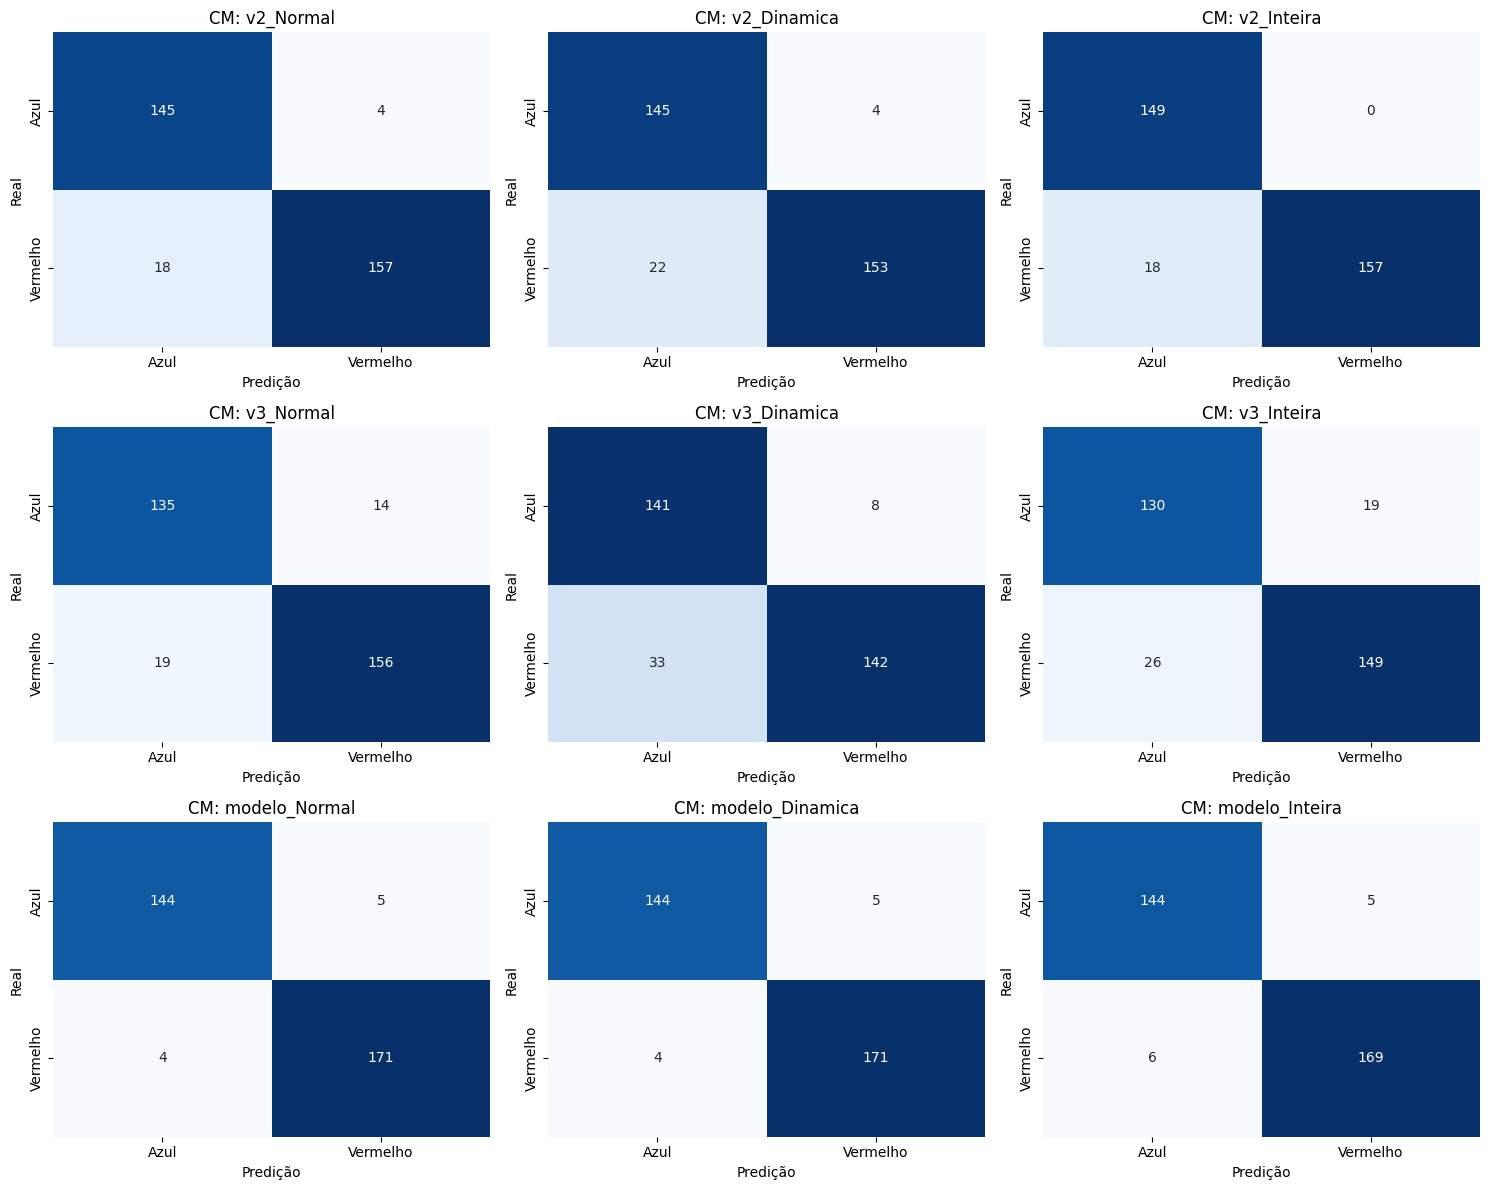

In [16]:
modelos_a_comparar = [
    {'nome': 'v2_Normal', 'caminho': 'v2_Normal.tflite', 'tipo': 'float'},
    {'nome': 'v2_Inteira', 'caminho': 'v2_Inteira.tflite', 'tipo': 'int8'},

    {'nome': 'v3_Normal', 'caminho': 'v3_Normal.tflite', 'tipo': 'float'},
    {'nome': 'v3_Dinamica', 'caminho': 'v3_Dinamica.tflite', 'tipo': 'float'},
    {'nome': 'v3_Inteira', 'caminho': 'v3_Inteira.tflite', 'tipo': 'int8'},

    {'nome': 'modelo_Normal', 'caminho': 'modelo_Normal.tflite', 'tipo': 'float'},
    {'nome': 'modelo_Dinamica', 'caminho': 'modelo_Dinamica.tflite', 'tipo': 'float'},
    {'nome': 'modelo_Inteira', 'caminho': 'modelo_Inteira.tflite', 'tipo': 'int8'},
]

class_labels = ['Azul', 'Vermelho']

resultados = comparar_modelos(modelos_a_comparar, X_teste, y_teste, class_labels)

### **Metricas**

In [39]:
# ============================================================
# 1) Converter 'resultados' em DataFrame base
# ============================================================

df_resultados = pd.DataFrame(resultados)

if "CM" in df_resultados.columns:
    df_resultados = df_resultados.drop(columns=["CM"])

df_resultados = df_resultados.set_index("Modelo")


# ============================================================
# 2) Adicionar tamanho dos arquivos TFLite
# ============================================================

tamanhos_dict = {}

for config in modelos_a_comparar:
    nome = config['nome']
    caminho = config['caminho']

    if os.path.exists(caminho):
        bytes_val = os.path.getsize(caminho)
        kb_val = bytes_val / 1024
        mb_val = bytes_val / (1024 * 1024)
        tamanhos_dict[nome] = {'Tamanho (KB)': kb_val, 'Tamanho (MB)': mb_val}
    else:
        print(f"❌ Arquivo não encontrado: {caminho}")
        tamanhos_dict[nome] = {'Tamanho (KB)': 0, 'Tamanho (MB)': 0}

df_tamanhos = pd.DataFrame.from_dict(tamanhos_dict, orient='index')


# ============================================================
# 3) Abrir arquivo CSV: arena_results.csv
# ============================================================

csv_path = "arena_results.csv"

if os.path.exists(csv_path):
    df_arena = pd.read_csv(csv_path)
    df_arena = df_arena.set_index("modelo")
    df_arena = df_arena.rename(columns={
        "arena_kb": "Arena (KB)",
        "arena_mb": "Arena (MB)",
        "reducao_percent": "Arena Redução (%)"
    })
else:
    print("⚠️ CSV 'arena_results.csv' não foi encontrado!")
    df_arena = pd.DataFrame()


# ============================================================
# 4) Juntar tudo em um único DataFrame
# ============================================================

df_final = df_resultados.join(df_tamanhos, how="left")

if not df_arena.empty:
    df_final = df_final.join(df_arena, how="left")


# ============================================================
# 5) Calcular redução de tamanho (KB) em relação ao modelo _Normal
# ============================================================

def calcular_reducao(row):
    try:
        partes = row.name.split('_')
        versao = partes[0]       # modelo, v2, v3
        base_nome = f"{versao}_Normal"

        tamanho_base = df_final.loc[base_nome, 'Tamanho (KB)']

        if tamanho_base == 0:
            return 0.0

        return (1 - (row['Tamanho (KB)'] / tamanho_base)) * 100

    except:
        return 0.0

df_final["Redução (%)"] = df_final.apply(calcular_reducao, axis=1)


# ============================================================
# 6) Exibir tabela final e organizada
# ============================================================

colunas_exibicao = [
    'Acurácia',
    'F1-Score (Média)',
    'Tamanho (KB)',
    'Tamanho (MB)',
    'Arena (KB)',
    'Arena (MB)',
    'Arena Redução (%)',
    'Redução (%)'
]

colunas_existentes = [c for c in colunas_exibicao if c in df_final.columns]

print("\n### 🔥 Tabela Final Consolidada ###")
print(df_final[colunas_existentes].to_markdown(floatfmt=".4f"))



### 🔥 Tabela Final Consolidada ###
| Modelo          |   Acurácia |   F1-Score (Média) |   Tamanho (KB) |   Tamanho (MB) |   Arena (KB) |   Arena (MB) |   Arena Redução (%) |   Redução (%) |
|:----------------|-----------:|-------------------:|---------------:|---------------:|-------------:|-------------:|--------------------:|--------------:|
| v2_Normal       |     0.9321 |             0.9320 |      8817.4609 |         8.6108 |     268.9840 |       0.2627 |              0.0000 |        0.0000 |
| v2_Dinamica     |     0.9198 |             0.9197 |      2488.6016 |         2.4303 |     268.9840 |       0.2627 |              0.0000 |       71.7764 |
| v2_Inteira      |     0.9444 |             0.9444 |      2687.1016 |         2.6241 |     179.0470 |       0.1749 |             33.4360 |       69.5252 |
| v3_Normal       |     0.8981 |             0.8977 |      3712.4180 |         3.6254 |     123.6410 |       0.1207 |              0.0000 |        0.0000 |
| v3_Dinamica     |     0.87

### **Preparação**

In [18]:
df_plot = df_final.reset_index()

df_plot['Arquitetura'] = df_plot['Modelo'].apply(lambda x: x.split('_')[0])
df_plot['Tipo'] = df_plot['Modelo'].apply(lambda x: x.split('_')[1])

ordem_tipos = ['Normal', 'Dinamica', 'Inteira']
df_plot['Tipo'] = pd.Categorical(df_plot['Tipo'], categories=ordem_tipos, ordered=True)

sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 11})

### **Grafico comparativo**

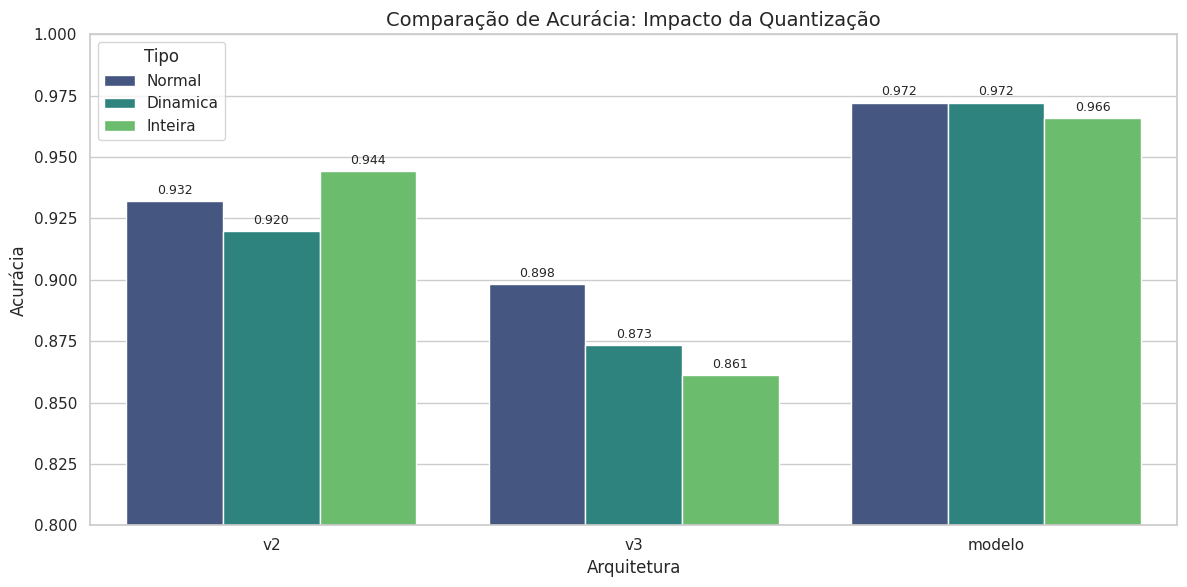

In [21]:
plt.figure(figsize=(12, 6))
ax1 = sns.barplot(data=df_plot, x='Arquitetura', y='Acurácia', hue='Tipo', palette='viridis')
plt.ylim(0.8, 1.0)
plt.title('Comparação de Acurácia: Impacto da Quantização', fontsize=14)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.3f', padding=3, fontsize=9)
plt.tight_layout()
plt.show()

### **Grafico de Sensibilidade**

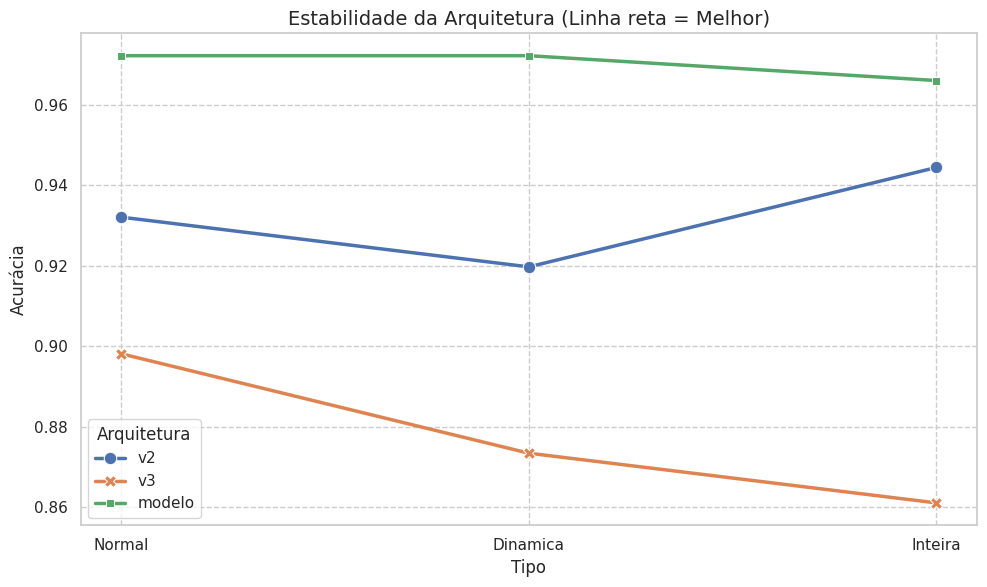

In [22]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_plot, x='Tipo', y='Acurácia', hue='Arquitetura', style='Arquitetura',
    markers=True, dashes=False, linewidth=2.5, markersize=9, palette='deep'
)
plt.title('Estabilidade da Arquitetura (Linha reta = Melhor)', fontsize=14)
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

### **Grafico de Perdas**

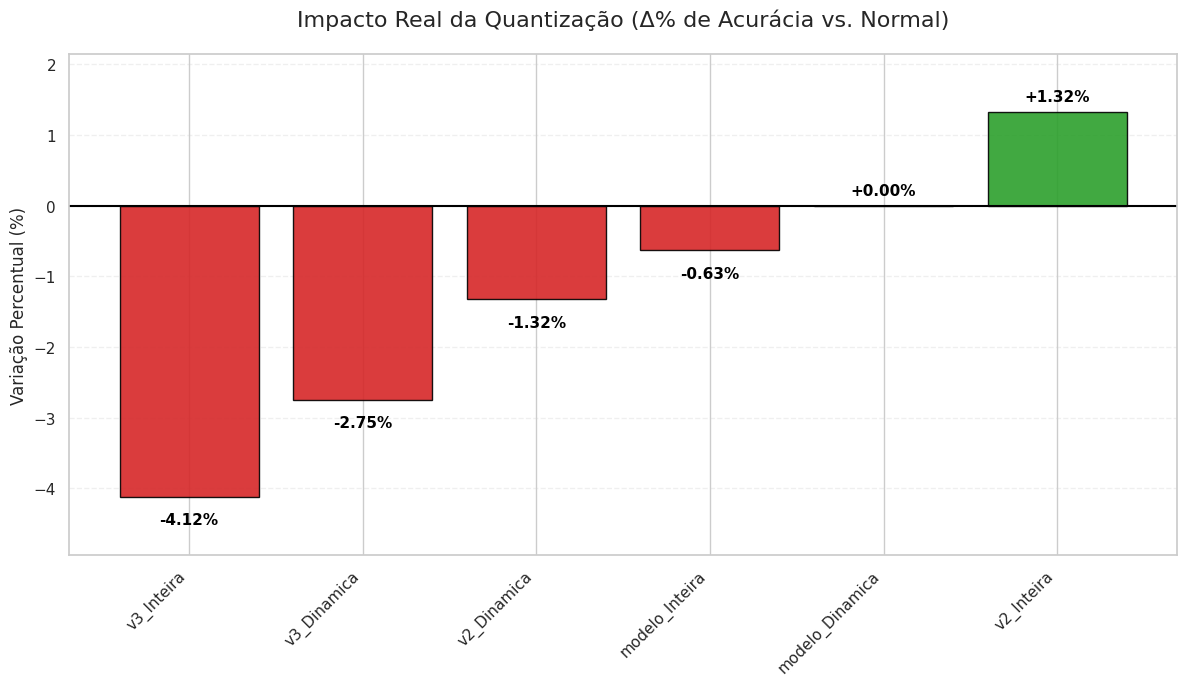

In [47]:
df_delta = df_plot.copy()

df_delta[['Arquitetura', 'Tipo']] = df_delta['Modelo'].str.rsplit('_', n=1, expand=True)

bases_map = df_delta[df_delta['Tipo'] == 'Normal'].set_index('Arquitetura')['Acurácia'].to_dict()

def calcular_delta_robusto(row):
    if row['Tipo'] == 'Normal':
        return np.nan

    acc_base = bases_map.get(row['Arquitetura'])

    if acc_base is None:
        return np.nan

    return ((row['Acurácia'] - acc_base) / acc_base) * 100

df_delta["Delta (%)"] = df_delta.apply(calcular_delta_robusto, axis=1)

df_delta_plot = df_delta.dropna(subset=["Delta (%)"]).sort_values("Delta (%)")

plt.figure(figsize=(12, 7))

cores = ['#2ca02c' if d >= 0 else '#d62728' for d in df_delta_plot['Delta (%)']]

bars = plt.bar(
    df_delta_plot['Modelo'],
    df_delta_plot['Delta (%)'],
    color=cores,
    edgecolor='black',
    alpha=0.9
)

plt.axhline(0, color='black', linewidth=1.5)
plt.title("Impacto Real da Quantização (Δ% de Acurácia vs. Normal)", fontsize=16, pad=20)
plt.ylabel("Variação Percentual (%)", fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.3)

y_max = df_delta_plot['Delta (%)'].max()
y_min = df_delta_plot['Delta (%)'].min()
margin = (y_max - y_min) * 0.15 if y_max != y_min else 1.0
plt.ylim(y_min - margin, y_max + margin)

offset = (y_max - y_min) * 0.02
for bar in bars:
    height = bar.get_height()
    label_y_pos = height + offset if height >= 0 else height - offset * 2

    plt.text(
        bar.get_x() + bar.get_width()/2,
        label_y_pos,
        f"{height:+.2f}%",
        ha='center',
        va='bottom' if height >= 0 else 'top',
        fontsize=11,
        fontweight='bold',
        color='black'
    )

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **Grafico de Calor**

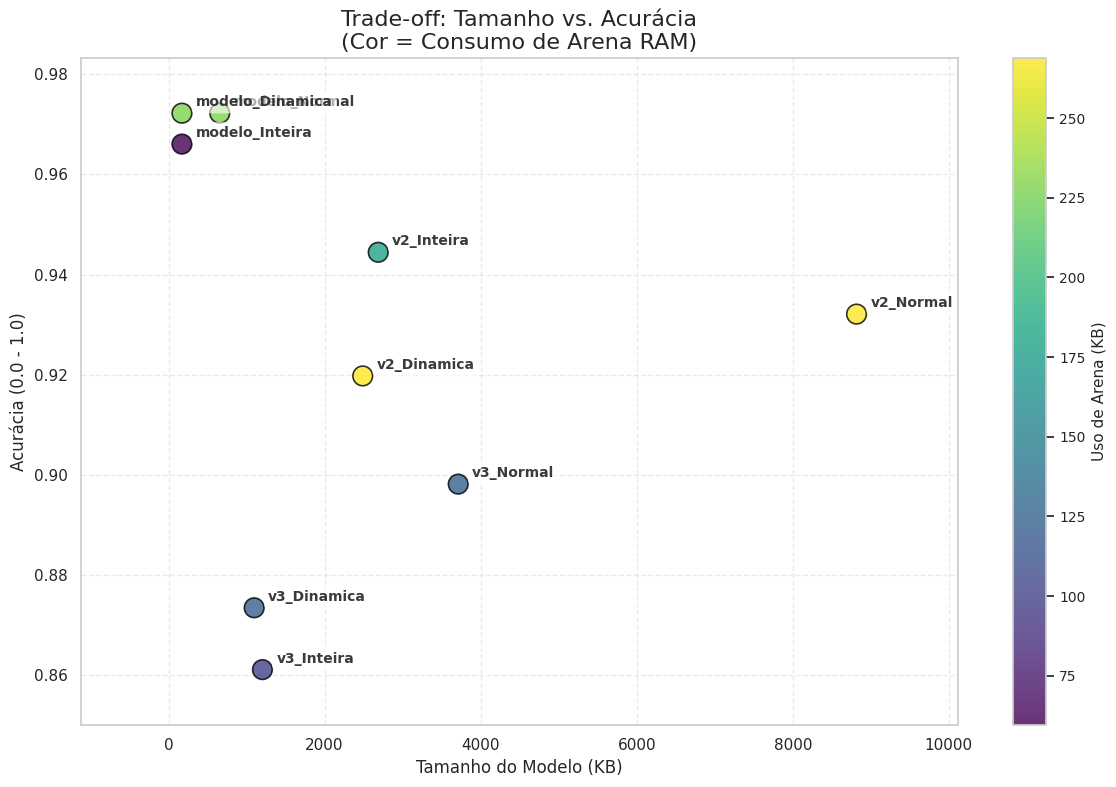

In [48]:
plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    df_plot['Tamanho (KB)'],
    df_plot['Acurácia'],
    s=200,
    c=df_plot['Arena (KB)'],
    cmap='viridis',
    alpha=0.8,
    edgecolor='black',
    linewidth=1.2,
    zorder=2
)

for i, row in df_plot.iterrows():
    plt.annotate(
        row['Modelo'],
        xy=(row['Tamanho (KB)'], row['Acurácia']),
        xytext=(10, 5),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        alpha=0.9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.6)
    )

plt.title("Trade-off: Tamanho vs. Acurácia\n(Cor = Consumo de Arena RAM)", fontsize=16)
plt.xlabel("Tamanho do Modelo (KB)", fontsize=12)
plt.ylabel("Acurácia (0.0 - 1.0)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.4, zorder=1)

plt.margins(x=0.15, y=0.1)

cbar = plt.colorbar(scatter)
cbar.set_label("Uso de Arena (KB)", fontsize=11)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

### **Grafico Acuracia X Tamanho do modelo**

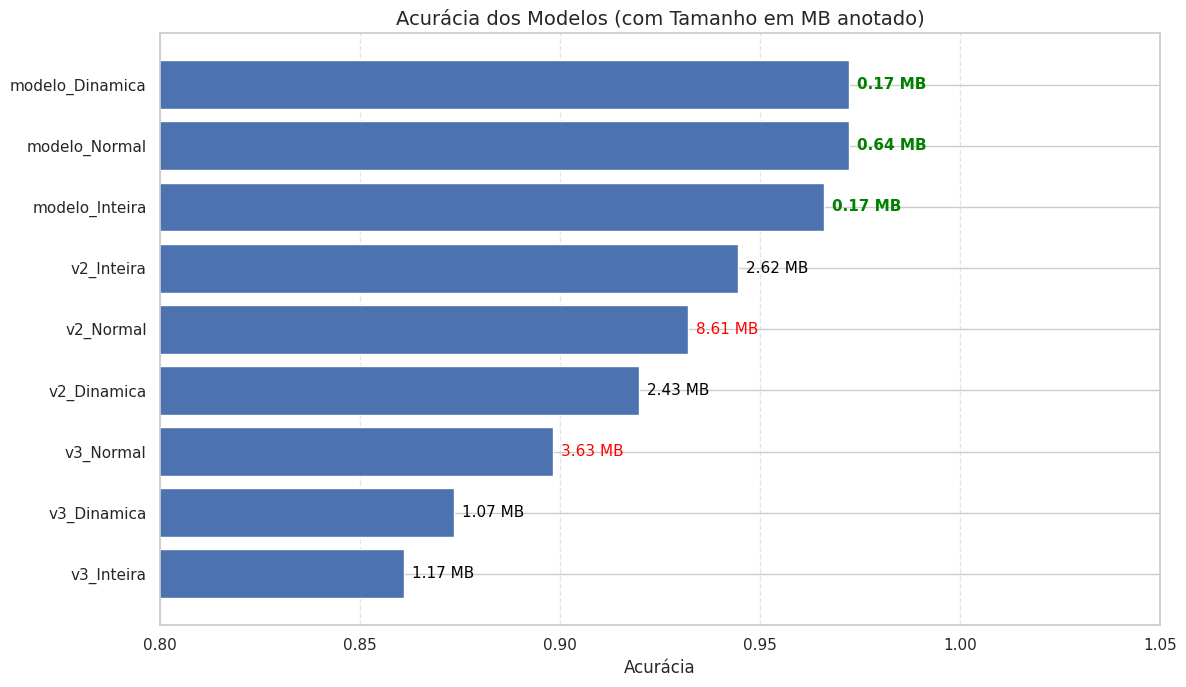

In [39]:
df_h = df_plot.sort_values('Acurácia', ascending=True)

plt.figure(figsize=(12, 7))

barras = plt.barh(df_h['Modelo'], df_h['Acurácia'], color='#4c72b0')

plt.xlim(0.8, 1.05)
plt.title('Acurácia dos Modelos (com Tamanho em MB anotado)', fontsize=14)
plt.xlabel('Acurácia')

for i, bar in enumerate(barras):
    tamanho = df_h['Tamanho (MB)'].iloc[i]
    tipo = df_h['Tipo'].iloc[i]
    acc = df_h['Acurácia'].iloc[i]

    cor_texto = 'red' if tamanho > 3 else ('green' if tamanho < 1 else 'black')
    weight = 'bold' if tamanho < 1 else 'normal'

    plt.text(
        acc + 0.002,
        bar.get_y() + bar.get_height()/2,
        f'{tamanho:.2f} MB',
        va='center',
        color=cor_texto,
        fontsize=11,
        fontweight=weight
    )

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **Grafico Modelo X Arena Size**

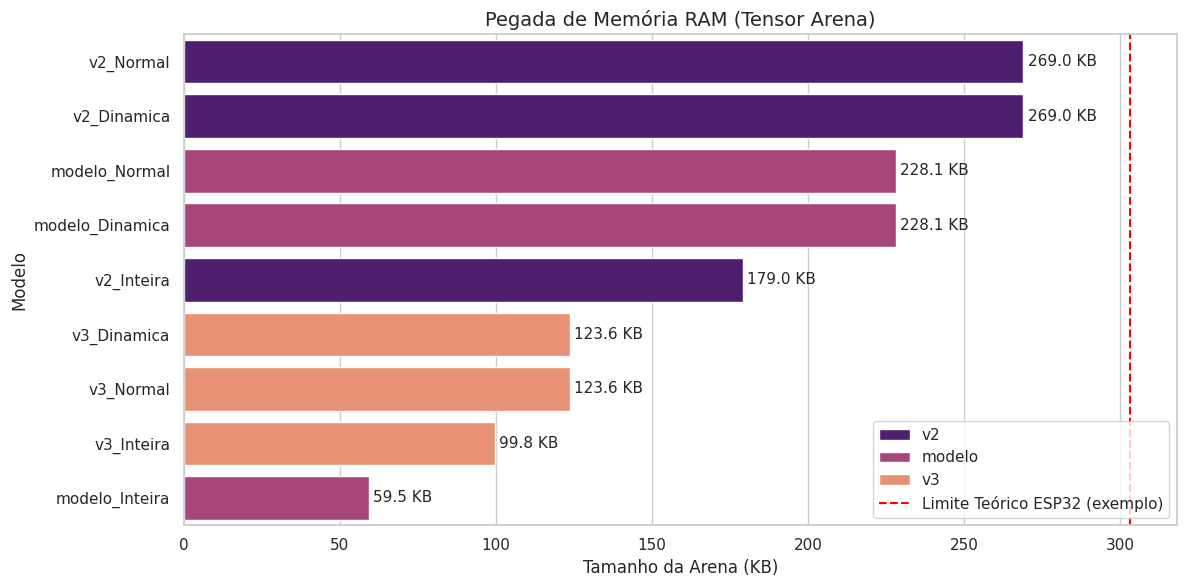

In [49]:
plt.figure(figsize=(12, 6))

df_sorted = df_plot.sort_values('Arena (KB)', ascending=False)

ax = sns.barplot(
    data=df_sorted,
    x='Arena (KB)',
    y='Modelo',
    hue='Arquitetura',
    dodge=False,
    palette='magma'
)

plt.title('Pegada de Memória RAM (Tensor Arena)', fontsize=14)
plt.xlabel('Tamanho da Arena (KB)')
plt.axvline(x=303, color='red', linestyle='--', label='Limite Teórico ESP32 (exemplo)')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f KB', padding=3)

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# **Site para verificar a estrutura da rede**
https://netron.app/

# Conclusão da Análise de Modelos TFLite no ESP32-S3 DevKitC 1

---

## Contexto da Análise

Nesta análise, comparamos diferentes versões de modelos de aprendizado de máquina treinados para a tarefa específica, avaliando **acurácia, F1-score, tamanho do modelo e consumo de memória (arena)** no ESP32-S3.  

O objetivo foi identificar quais modelos podem ser executados de forma eficiente no microcontrolador, respeitando os limites de memória interna e evitando falhas de alocação.

---

## Observações Importantes

- O **ESP32-S3 DevKitC 1** possui **~512 KB de SRAM**, **8 MB de PSRAM**, e **~361 KB de heap livre** para o uso da arena do TensorFlow Lite Micro.  
- Considerando a maior alocação segura para a arena (~280–290 KB), modelos que ultrapassam esse valor podem **não funcionar** corretamente.  
- O **modelo Dinâmico** (`v2_Dinamica`, `v3_Dinamica`, `modelo_Dinamica`) **não é suportado pelo TensorFlow Lite Micro**, que só aceita modelos estáticos (quantizados ou float fixo). Portanto, mesmo com métricas calculadas, esses modelos devem ser **desconsiderados** para execução real no ESP32-S3.  
- Modelos baseados em **MobileNet v3** apresentam **redução de desempenho após a conversão e quantização**, mesmo que a acurácia no arquivo `.keras` tenha sido boa.  

---

## Tabela Final Consolidada (Modelos Executáveis)

| Modelo        | Acurácia | F1-Score | Tamanho (KB) | Arena (KB) | Arena Redução (%) | Redução (%) |
|:--------------|---------:|---------:|-------------:|-----------:|-----------------:|------------:|
| v2_Normal     | 0.9321   | 0.9320   | 8817.46      | 268.98     | 0.00             | 0.00        |
| v2_Inteira    | 0.9444   | 0.9444   | 2687.10      | 179.05     | 33.44            | 69.53       |
| v3_Normal     | 0.8981   | 0.8977   | 3712.42      | 123.64     | 0.00             | 0.00        |
| v3_Inteira    | 0.8611   | 0.8606   | 1203.08      | 99.75      | 19.32            | 67.59       |
| modelo_Normal | 0.9722   | 0.9720   | 656.02       | 228.14     | 0.00             | 0.00        |
| modelo_Inteira| 0.9660   | 0.9658   | 171.69       | 59.45      | 73.94            | 73.83       |

> **Nota:** Modelos Dinâmicos (`*_Dinamica`) foram calculados para fins comparativos, mas não podem ser executados no TFLite Micro.  

---

## Conclusões

1. **Modelos Normais e Inteiros** podem ser executados no ESP32-S3 sem ultrapassar a memória da arena.  
2. A **redução de arena** é mais significativa em modelos inteiros (`Inteira`), permitindo **uso mais eficiente da RAM** sem grandes perdas de acurácia.  
3. O **modelo `modelo_Normal`** oferece excelente acurácia e ainda mantém a arena dentro do limite seguro (~228 KB).  
4. O **modelo `modelo_Inteira`** é extremamente leve, ocupando apenas ~59 KB de arena, tornando-o ideal para aplicações com **restrições severas de memória**, mesmo com uma pequena queda de acurácia.  
5. Modelos dinâmicos devem ser **desconsiderados**, pois não são suportados pela biblioteca TFLite Micro.  
6. Modelos **MobileNet v3** apresentam **redução de desempenho após a conversão e quantização**, mesmo com boa acurácia no `.keras`.

---

## Recomendação

Para projetos no **ESP32-S3 DevKitC 1**, os modelos **estáticos** (Normais ou Inteiros) são os **mais indicados**, equilibrando desempenho, acurácia e consumo de memória.  

- Escolha modelos **Inteiros (`Inteira`)** quando **economia de memória** for prioridade.  
- Escolha modelos **Normais** quando **acurácia máxima** for desejada, mesmo com arena maior.
